## Setup environment

In [1]:
from swincell import utils

In the future `np.bool` will be defined as the corresponding NumPy scalar.
In the future `np.bool` will be defined as the corresponding NumPy scalar.
In the future `np.bool` will be defined as the corresponding NumPy scalar.
torch.backends.cuda.matmul.allow_tf32 = True by default.
  This value defaults to True when PyTorch version in [1.7, 1.11] and may affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


# compare model performance

In [10]:
# show results
from natsort import natsorted
import tifffile 
import glob
import numpy as np
root_folder = '/data/download_data/quilt-data-access-tutorials-main/all_fov/allen100'
image_files = natsorted(glob.glob(root_folder + '/images/*.tiff'))
seg_files = natsorted(glob.glob(root_folder + '/masks/*.tiff'))
# print(seg_files)
valid_img_files = image_files[::5]
valid_seg_files = seg_files[::5]



# raw_img_folder = root_folder + '/images/[1,6].tiff'
#  before training 2d
results_2d_folder_algo1 = root_folder + '/results_2d_cellpose_algo1/*.tiff'
results_2d_folder_algo2 = root_folder + '/results_2d_cellpose_algo2/*.tiff'
# after training 2d
# choose the best threshold and diameter to compare with 3d cellpose
thre = 0.075
dia = 75
results_2d_folder_algo1_after_training = root_folder + '/results_2d_cellpose_algo1_after_training/*pred.tiff'
results_2d_folder_algo2_after_training = root_folder + '/results_2d_cellpose_algo2_after_training/*' + 'thre_' +str(thre)+ '_dia_' + str(dia) + '.tiff'

# after training 3d
results_3d_folder = root_folder + '/results_3d_monai_minsize50000/*.tiff'
# results_3d_folder = root_folder + '/results_3d_monai_minsize2500/*.tiff'

# Ground truth
# gt_folder = root_folder + '/masks/*.tiff'
gt_files = valid_seg_files


results_2d_files_algo1 = natsorted(glob.glob(results_2d_folder_algo1))
results_2d_files_algo2 = natsorted(glob.glob(results_2d_folder_algo2))

results_2d_files_algo1_after_training = natsorted(glob.glob(results_2d_folder_algo1_after_training))
results_2d_files_algo2_after_training = natsorted(glob.glob(results_2d_folder_algo2_after_training))


# results_3d_files = natsorted(glob.glob(results_3d_folder))[::5]
results_3d_files = natsorted(glob.glob(results_3d_folder))

raw_image_files = valid_img_files
# print(results_2d_files_algo1,results_2d_files_algo2,results_3d_files,gt_files)
print(len(raw_image_files),len(results_2d_files_algo1),len(results_3d_files),len(gt_files),len(results_2d_files_algo1_after_training),len(results_2d_files_algo2_after_training))

20 20 20 20 20 20


# model eval with differernt inference parameters

In [3]:
from swincell.utils.utils import matching
import pandas as pd
N_thresholds =15
mAP_2d_algo1_list =np.zeros((len(results_2d_files_algo1),N_thresholds))
mAP_2d_algo2_list =np.zeros((len(results_2d_files_algo2),N_thresholds))
mAP_2d_algo1_after_training_list =np.zeros((len(results_2d_files_algo1_after_training),N_thresholds))
mAP_2d_algo2_after_training_list =np.zeros((len(results_2d_files_algo2_after_training),N_thresholds))
mAP_3d_list =np.zeros((len(results_3d_files),N_thresholds))
output = pd.DataFrame()
for i in range(len(results_2d_files_algo1)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
    # threshold = 0.5
        gt_img = tifffile.imread(gt_files[i])
        # results 3d
        img_3d = tifffile.imread(results_3d_files[i])
        # results 2d
        img_2d_algo1 = tifffile.imread(results_2d_files_algo1[i])
        img_2d_algo2 = tifffile.imread(results_2d_files_algo2[i])  
        img_2d_algo1_after_training = tifffile.imread(results_2d_files_algo1_after_training[i])
        img_2d_algo2_after_training = tifffile.imread(results_2d_files_algo2_after_training[i])  

        # mAP_3d = matching(img_3d, gt_img, thresh=threshold).precision
        # mAP_2d_algo1 = matching(img_2d_algo1, gt_img, thresh=threshold).precision
        # mAP_2d_algo2 = matching(img_2d_algo2, gt_img, thresh=threshold).precision
        # mAP_2d_algo1_after_training = matching(img_2d_algo1_after_training, gt_img, thresh=threshold).precision
        # mAP_2d_algo2_after_training = matching(img_2d_algo2_after_training, gt_img, thresh=threshold).precision
        mAP_3d = matching(gt_img,img_3d,  thresh=threshold)
        mAP_2d_algo1 = matching(gt_img,img_2d_algo1, thresh=threshold)
        mAP_2d_algo2 = matching(gt_img,img_2d_algo2, thresh=threshold)
        mAP_2d_algo1_after_training = matching(gt_img,img_2d_algo1_after_training, thresh=threshold)
        mAP_2d_algo2_after_training = matching(gt_img,img_2d_algo2_after_training, thresh=threshold)

        df_temp = pd.DataFrame([mAP_3d])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = 'swincell'
        output = pd.concat([output,df_temp])

        df_temp = pd.DataFrame([mAP_2d_algo1])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = '2d cellpose algo1'
        output = pd.concat([output,df_temp])

        df_temp = pd.DataFrame([mAP_2d_algo2])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = '2d cellpose algo2'
        output = pd.concat([output,df_temp])

        df_temp = pd.DataFrame([mAP_2d_algo1_after_training])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = '2d cellpose algo1 after training'
        output = pd.concat([output,df_temp])

        df_temp = pd.DataFrame([mAP_2d_algo2_after_training])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = '2d cellpose algo2 after training'
        output = pd.concat([output,df_temp])
    
 
print(output.head(20))

  criterion  thresh     fp  tp  fn  precision    recall  accuracy        f1  \
0       iou     0.5      2  30   4   0.937500  0.882353  0.833333  0.909091   
0       iou     0.5   1428  23  11   0.015851  0.676471  0.015732  0.030976   
0       iou     0.5     40  24  10   0.375000  0.705882  0.324324  0.489796   
0       iou     0.5    752  27   7   0.034660  0.794118  0.034351  0.066421   
0       iou     0.5      7  34   0   0.829268  1.000000  0.829268  0.906667   
0       iou     0.5      1  38   9   0.974359  0.808511  0.791667  0.883721   
0       iou     0.5  13551   7  40   0.000516  0.148936  0.000515  0.001029   
0       iou     0.5     89   5  42   0.053191  0.106383  0.036765  0.070922   
0       iou     0.5   5152  26  21   0.005021  0.553191  0.005001  0.009952   
0       iou     0.5     44  36  11   0.450000  0.765957  0.395604  0.566929   
0       iou     0.5      1  27   4   0.964286  0.870968  0.843750  0.915254   
0       iou     0.5   2367  18  13   0.007547  0.580

# Save calculated results for future use

In [18]:
# write calculated results into a csv file, save results for future use
# output.head(20)
# output.to_csv('./output_Allen_15steps_new.csv')

## load previous results

In [24]:


# load precomputed results or calculate them-------------------------------
import pandas as pd
import numpy as np
N_thresholds = 15
output = pd.read_csv('../../results/output_Allen_15steps_1.csv') # load precomputed results
# output = pd.read_csv('./output_Allen_15steps_new.csv') # load precomputed results
#---------------------------------------------------


In [25]:
output_3d= output[output['method']=='swincell']
# output_3d= output[output['method']=='3d cellpose']
output_2d_algo1= output[output['method']=='2d cellpose algo1']
output_2d_algo2= output[output['method']=='2d cellpose algo2']
output_2d_algo1_after_training= output[output['method']=='2d cellpose algo1 after training']
output_2d_algo2_after_training= output[output['method']=='2d cellpose algo2 after training']

mAP_3d_list =output_3d['precision'].values.reshape(20,N_thresholds)
mAP_2d_algo1_list =output_2d_algo1['precision'].values.reshape(20,N_thresholds)
mAP_2d_algo2_list =output_2d_algo2['precision'].values.reshape(20,N_thresholds)
mAP_2d_algo1_after_training_list =output_2d_algo1_after_training['precision'].values.reshape(20,N_thresholds)
mAP_2d_algo2_after_training_list =output_2d_algo2_after_training['precision'].values.reshape(20,N_thresholds)

output_3d.head(10)

,Unnamed: 0,Unnamed: 0.1,criterion,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,img_id,method
0,0,0,iou,0.500000,1,33,8,0.970588,0.804878,0.785714,0.880000,41,34,0.737124,0.915821,0.805922,1.tiff,swincell
5,5,0,iou,0.535714,1,33,8,0.970588,0.804878,0.785714,0.880000,41,34,0.737124,0.915821,0.805922,1.tiff,swincell
10,10,0,iou,0.571429,1,33,8,0.970588,0.804878,0.785714,0.880000,41,34,0.737124,0.915821,0.805922,1.tiff,swincell
15,15,0,iou,0.607143,1,33,8,0.970588,0.804878,0.785714,0.880000,41,34,0.737124,0.915821,0.805922,1.tiff,swincell
20,20,0,iou,0.642857,2,32,9,0.941176,0.780488,0.744186,0.853333,41,34,0.721599,0.924549,0.788949,1.tiff,swincell
25,25,0,iou,0.678571,3,31,10,0.911765,0.756098,0.704545,0.826667,41,34,0.705473,0.933045,0.771317,1.tiff,swincell
30,30,0,iou,0.714286,3,31,10,0.911765,0.756098,0.704545,0.826667,41,34,0.705473,0.933045,0.771317,1.tiff,swincell
35,35,0,iou,0.750000,3,31,10,0.911765,0.756098,0.704545,0.826667,41,34,0.705473,0.933045,0.771317,1.tiff,swincell
40,40,0,iou,0.785714,4,30,11,0.882353,0.731707,0.666667,0.800000,41,34,0.687036,0.938949,0.751159,1.tiff,swincell
45,45,0,iou,0.821429,4,30,11,0.882353,0.731707,0.666667,0.800000,41,34,0.687036,0.938949,0.751159,1.tiff,swincell


In [26]:
f1_3d_list =output_3d['f1'].values.reshape(20,N_thresholds)  # 20 is the Number of samples (20% used for testing), N_thresholds =15 or 5
f1_2d_algo1_list =output_2d_algo1['f1'].values.reshape(20,N_thresholds)
f1_2d_algo2_list =output_2d_algo2['f1'].values.reshape(20,N_thresholds)
f1_2d_algo1_after_training_list =output_2d_algo1_after_training['f1'].values.reshape(20,N_thresholds)
f1_2d_algo2_after_training_list =output_2d_algo2_after_training['f1'].values.reshape(20,N_thresholds)

precision_3d_list =output_3d['precision'].values.reshape(20,N_thresholds)  # 20 is the Number of samples (20% used for testing), N_thresholds =15 or 5
precision_2d_algo1_list =output_2d_algo1['precision'].values.reshape(20,N_thresholds)
precision_2d_algo2_list =output_2d_algo2['precision'].values.reshape(20,N_thresholds)
precision_2d_algo1_after_training_list =output_2d_algo1_after_training['precision'].values.reshape(20,N_thresholds)
precision_2d_algo2_after_training_list =output_2d_algo2_after_training['precision'].values.reshape(20,N_thresholds)

recall_3d_list =output_3d['recall'].values.reshape(20,N_thresholds)  # 20 is the Number of samples (20% used for testing), N_thresholds =15 or 5
recall_2d_algo1_list =output_2d_algo1['recall'].values.reshape(20,N_thresholds)
recall_2d_algo2_list =output_2d_algo2['recall'].values.reshape(20,N_thresholds)
recall_2d_algo1_after_training_list =output_2d_algo1_after_training['recall'].values.reshape(20,N_thresholds)
recall_2d_algo2_after_training_list =output_2d_algo2_after_training['recall'].values.reshape(20,N_thresholds)

mean_f1_at_thre05 = f1_3d_list[:,0].mean()
mAP_at_thre05 = precision_3d_list[:,0].mean()
recall_at_thre05 = recall_3d_list[:,0].mean()
print(mean_f1_at_thre05, mAP_at_thre05, recall_at_thre05)


0.8257335345672623 0.9514357263809787 0.7586472683083041


In [6]:
print(mAP_3d_list.shape,mAP_2d_algo1_list.shape,mAP_2d_algo2_list.shape,mAP_2d_algo1_after_training_list.shape,mAP_2d_algo2_after_training_list.shape)

(20, 15) (20, 15) (20, 15) (20, 15) (20, 15)


(20, 15)


[Text(1, 0, 'SwinCell'),
 Text(2, 0, 'Cellpose v1'),
 Text(3, 0, 'Cellpose v2'),
 Text(4, 0, 'V1 finetuned'),
 Text(5, 0, 'V2 finetuned')]

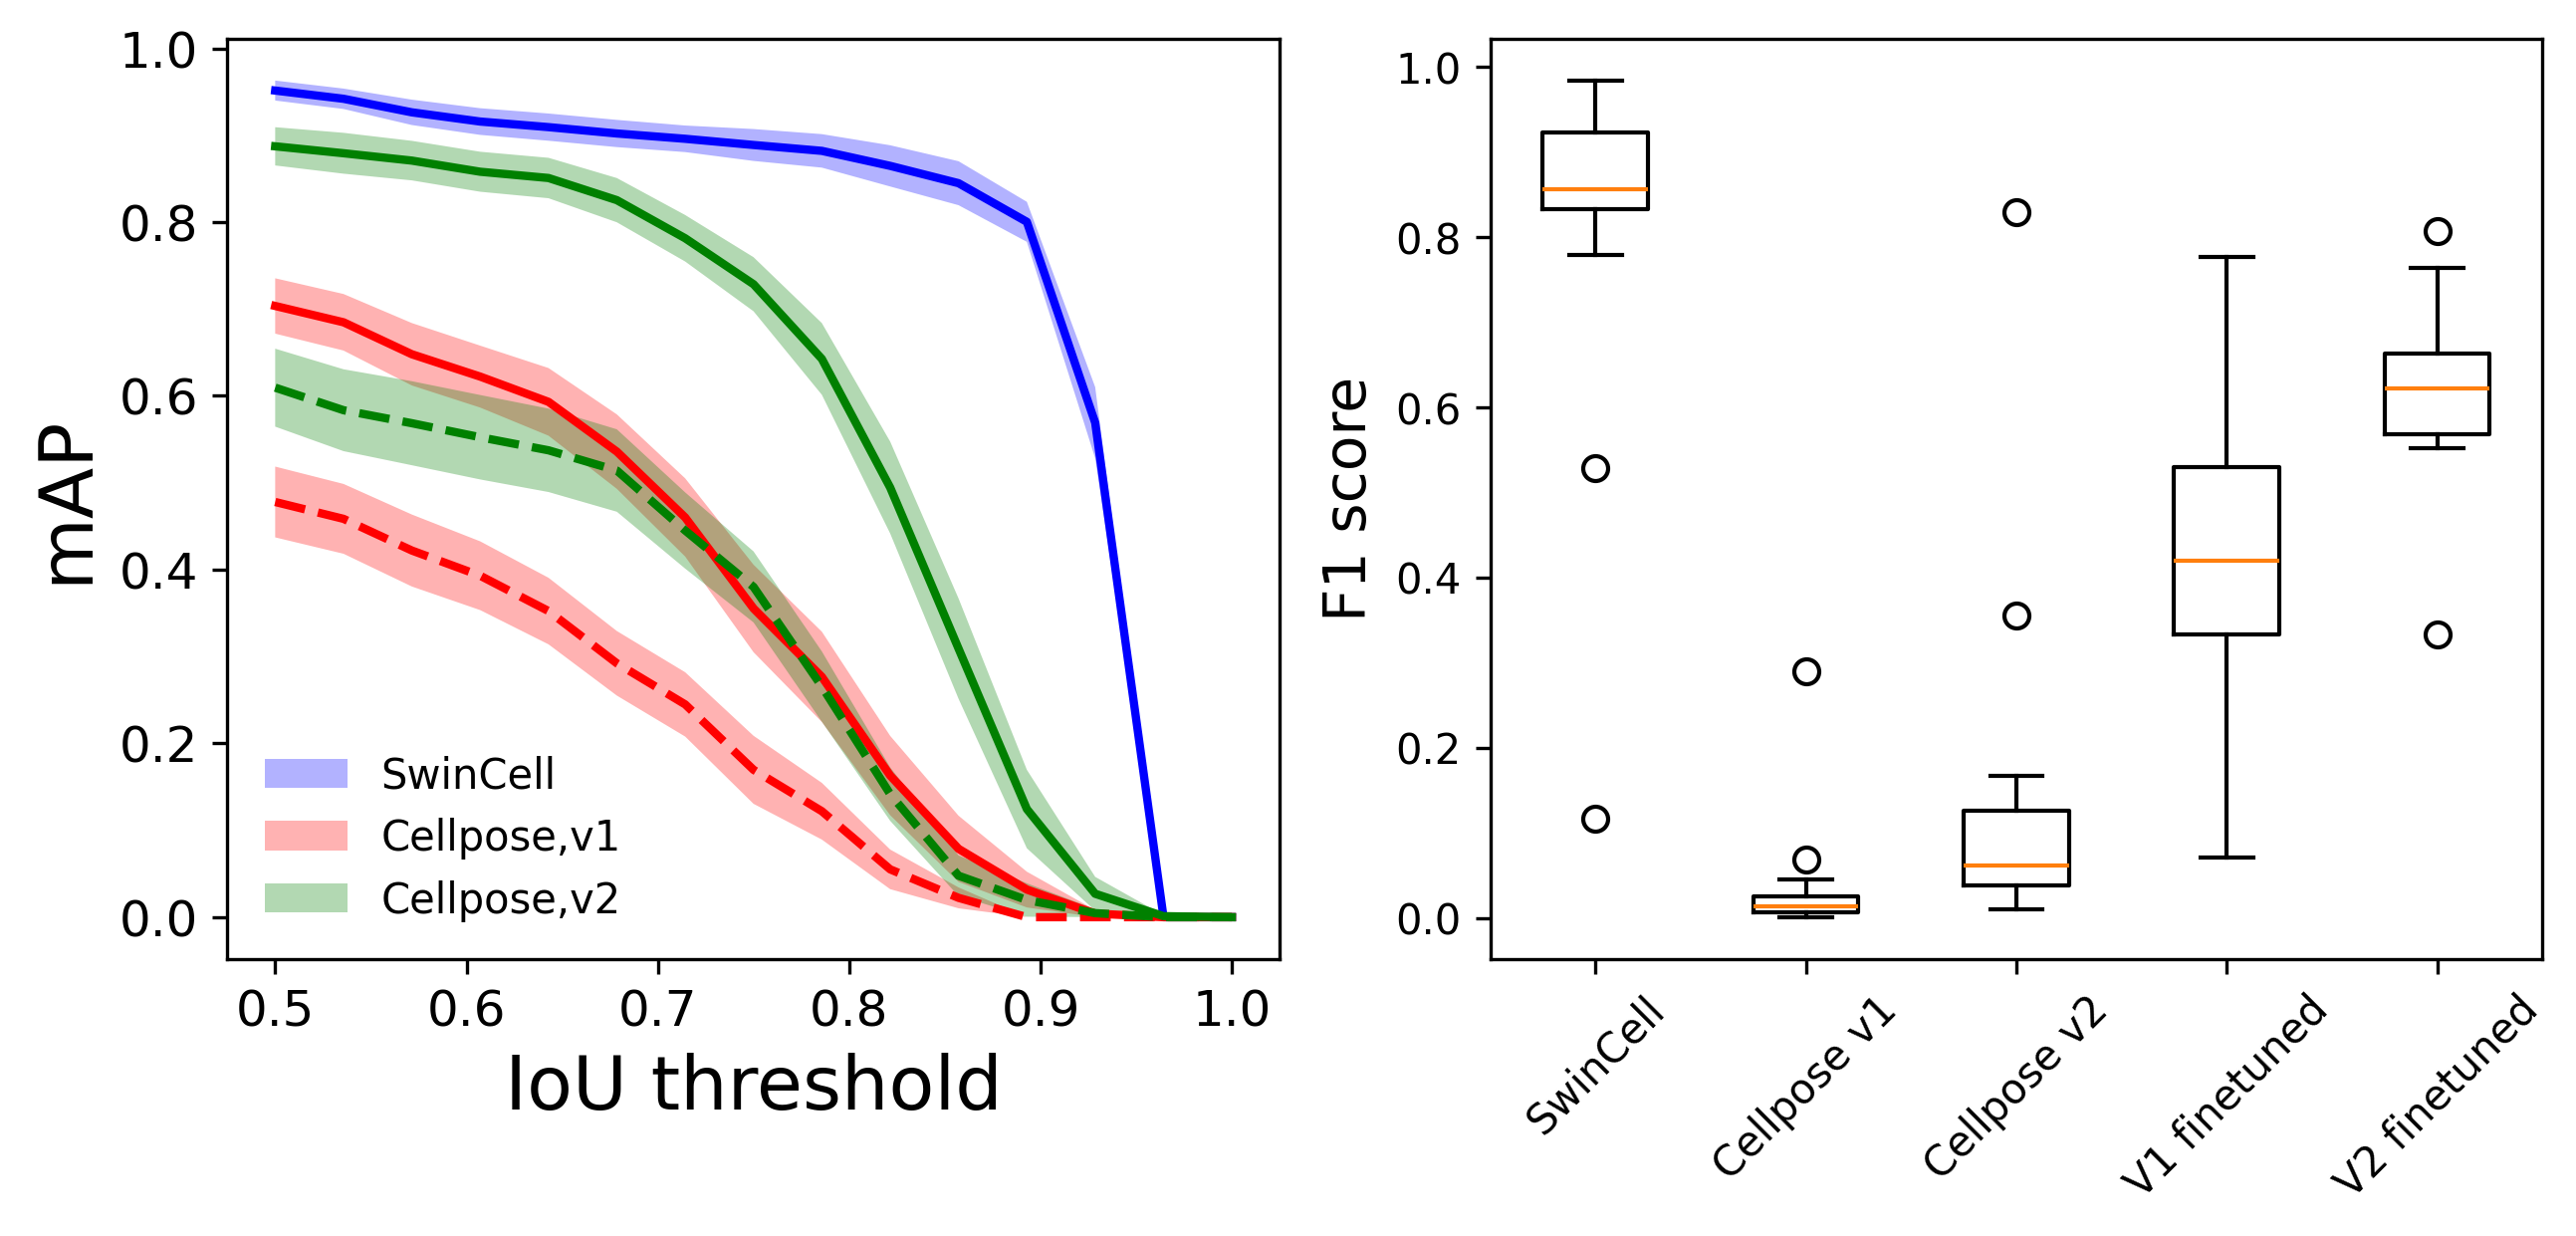

In [18]:
from matplotlib import pyplot as plt

from swincell.utils.utils import plot_with_se,plot_box_with_violin
iou_thresholds = np.linspace(0.5,1,N_thresholds)
# fig,ax = plt.subplots(1,2,figsize=(12,4), dpi=300)
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi=300)


plot_with_se(ax[0],mAP_3d_list,iou_thresholds,label='SwinCell',color='blue')
plot_with_se(ax[0],mAP_2d_algo1_list,iou_thresholds,style='--',color='red')
# plot_with_se(ax[0],mAP_2d_algo1_after_training_list,label='2D cellpose,v1, finetuned')
plot_with_se(ax[0],mAP_2d_algo1_after_training_list,iou_thresholds,label='Cellpose,v1', color='red')
plot_with_se(ax[0],mAP_2d_algo2_list,iou_thresholds,style='--',color='green')
# plot_with_se(ax[0],mAP_2d_algo2_after_training_list,label='2D cellpose,v2, finetuned')
plot_with_se(ax[0],mAP_2d_algo2_after_training_list,iou_thresholds,label='Cellpose,v2',color='green')
ax[0].legend(loc='lower left',frameon=False,fontsize=10)
ax[0].tick_params(labelsize=12)
ax[0].set_ylabel('mAP',fontsize =18)
ax[0].set_xlabel('IoU threshold',fontsize =18)

# add new legend
# lines = ax.get_lines()
# legend1 = plt.legend([lines[i] for i in [1,0]], ["pretrained", "finetuned"], loc=1)
# plt.gca().add_artist(legend1)

# F1 score barplot
x_pos =np.arange(2,7) 

print(f1_3d_list.shape)  # size =(Num_testImages, N_thresholds) or (20 * 15)
f1_means = [np.mean(f1_3d_list[:,0],axis=0),np.mean(f1_2d_algo1_list[:,0],axis=0),np.mean(f1_2d_algo2_list[:,0],axis=0),np.mean(f1_2d_algo1_after_training_list[:,0],axis=0),np.mean(f1_2d_algo2_after_training_list[:,0],axis=0)]
f1_se = [np.std(f1_3d_list[:,0],axis=0),np.std(f1_2d_algo1_list[:,0],axis=0),np.std(f1_2d_algo2_list[:,0],axis=0),np.std(f1_2d_algo1_after_training_list[:,0],axis=0),np.std(f1_2d_algo2_after_training_list[:,0],axis=0)]/np.sqrt(f1_2d_algo1_list.shape[0])
# ax[0][1].bar(x_pos, f1_means, yerr=f1_se, align='center', alpha=0.5, ecolor='black', capsize=10)
# # ax[0][1].set_xlabel('test')
# ax[0][1].set_xticks([xlabel])
# # ax[0][1].set_xticks([x_pos], xlabel)
# ax[0][1].set_ylim(0,1)
columns = [f1_3d_list[:,0],f1_2d_algo1_list[:,0],f1_2d_algo1_after_training_list[:,0],f1_2d_algo2_list[:,0],f1_2d_algo2_after_training_list[:,0]]

ax[1].boxplot(columns)
# ax[1].set_xticks([1, 2, 3, 4,5], ['3D','2D_v1','2D_v2','2D_v1_after_training','2D_v2_after_training'])
# ax[1].set_xticklabels(['Unet', 'SwinUnetr'],fontsize =16)

ax[1].set_ylabel('F1 score',fontsize =14)
ax[1].set_xticklabels(['SwinCell','Cellpose v1','Cellpose v2','V1 finetuned','V2 finetuned'],fontsize =10,rotation=45)




In [49]:
# # compare  results
# from swincell.utils.utils import matching

output_2d = pd.DataFrame()


N_thresholds=2

# thre_list = [0.5, 0.25,0.375,0.625,0.75]
thre_list = [ 0.075,0.125, 0.25,0.375,0.5,0.625,0.75]
dia_list = [25,50,75,100,125]
# iou_thresholds = np.linspace(0.5,1,N_thresholds)
iou_thresholds = 0.5
for dia in dia_list:
    for thre in thre_list:
        results_2d =  root_folder + '/results_2d_cellpose_algo2_after_training/*_thre_' +str(thre) + '*dia_'+str(dia) +'.tiff'
        files = natsorted(glob.glob(results_2d))
        for file_idx in range(len(files)):
            img_2d  = tifffile.imread(files[file_idx])
            gt_img = tifffile.imread(gt_files[file_idx])

            res_match = matching(gt_img,img_2d,  thresh=0.5)


            df_temp = pd.DataFrame([res_match])
            df_temp['img_id'] = str(gt_files[file_idx].split('/')[-1])
            df_temp['thre'] = thre
            df_temp['dia'] =dia

            output_2d = pd.concat([output_2d,df_temp])

        print(len(files))




20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


In [196]:
# model performance in descending order:
# stitching threshold: 0.25, 0.375,0.5, 0.625 ,0.75
# 50>100>>>25


In [30]:
# output_2d.head(20)
stat =output_2d.groupby(['thre']).mean()
stat.head(20)

,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,dia
thre,,,,,,,,,,,,,,
0.075,0.5,36.77,26.19,9.71,0.475015,0.723658,0.444126,0.569202,35.9,62.96,0.587922,0.765621,0.464359,75.0
0.125,0.5,36.83,26.19,9.71,0.474858,0.723658,0.443987,0.569091,35.9,63.02,0.587922,0.765621,0.464269,75.0
0.250,0.5,37.21,26.19,9.71,0.472103,0.723658,0.441456,0.567161,35.9,63.40,0.587924,0.765609,0.462696,75.0
0.375,0.5,39.43,26.18,9.72,0.452287,0.723380,0.423409,0.552631,35.9,65.61,0.587588,0.765402,0.450636,75.0
0.500,0.5,48.85,26.10,9.80,0.384822,0.720988,0.362493,0.498572,35.9,74.95,0.585206,0.764415,0.405975,75.0
0.625,0.5,74.48,25.70,10.20,0.272384,0.710335,0.260092,0.392054,35.9,100.18,0.575320,0.761329,0.318177,75.0
0.750,0.5,133.48,24.52,11.38,0.159018,0.679757,0.153495,0.256980,35.9,158.00,0.542679,0.739788,0.205333,75.0


In [31]:
stat_mean =output_2d.groupby(['dia','thre']).mean().reset_index()
stat_mean.head(50)

stat_se =output_2d.groupby(['dia','thre']).sem().reset_index()
stat_se.head(50)

,dia,thre,thresh,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality
0,25,0.075,0.0,10.616391,0.617614,1.928014,0.006555,0.015181,0.004547,0.008546,2.193171,10.906637,0.011238,0.057197,0.006231
1,25,0.125,0.0,10.683509,0.617614,1.928014,0.006560,0.015181,0.004551,0.008552,2.193171,10.971080,0.011238,0.057197,0.006235
2,25,0.250,0.0,10.743395,0.617614,1.928014,0.006499,0.015181,0.004510,0.008478,2.193171,11.033985,0.011238,0.057199,0.006190
3,25,0.375,0.0,10.969719,0.617614,1.928014,0.006414,0.015181,0.004452,0.008375,2.193171,11.262484,0.011191,0.057149,0.006099
4,25,0.500,0.0,11.936515,0.609033,1.950000,0.005641,0.015030,0.004060,0.007676,2.193171,12.224135,0.010984,0.057032,0.005553
5,25,0.625,0.0,14.987692,0.591497,1.951079,0.004865,0.014404,0.003530,0.006727,2.193171,15.260734,0.010417,0.056650,0.004835
6,25,0.750,0.0,20.758546,0.467918,2.000132,0.003298,0.011286,0.002362,0.004578,2.193171,20.922825,0.008249,0.060562,0.003185
7,50,0.075,0.0,2.985469,2.289880,0.753501,0.026555,0.026293,0.029156,0.026687,2.193171,4.078570,0.024806,0.008205,0.025528
8,50,0.125,0.0,2.977459,2.289880,0.753501,0.026445,0.026293,0.029065,0.026617,2.193171,4.070352,0.024806,0.008205,0.025484
9,50,0.250,0.0,2.963706,2.289880,0.753501,0.026215,0.026293,0.028945,0.026530,2.193171,4.055795,0.024809,0.008214,0.025452


Text(0.5, 0, 'Diameter (pixels)')

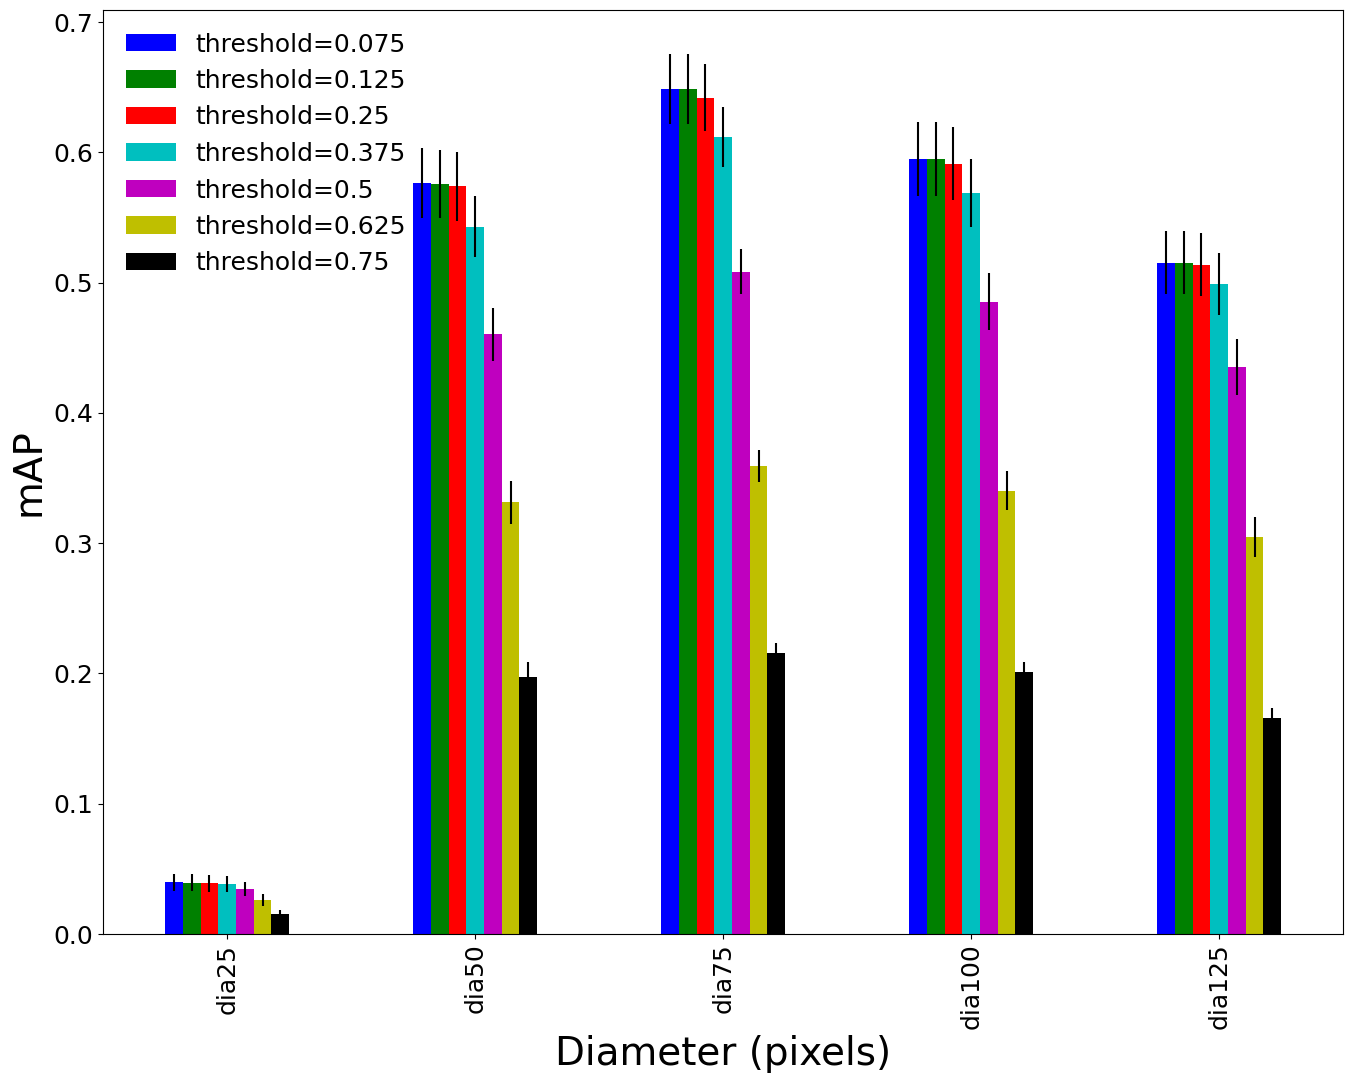

In [32]:
# res = stat1[stat1['dia']=='100']
# res.head()
thre_list = [ 0.075,0.125, 0.25,0.375,0.5,0.625,0.75]
#dia_list = [25,50,75,100,125]

df = pd.DataFrame()

grp1 = 'thre=0.075'
grp2 = 'thre=0.125'
grp3 = 'thre=0.250'
grp4 = 'thre=0.375'
grp5 = 'thre=0.500'
grp6 = 'thre=0.625'
grp7 = 'thre=0.750'                                             


df['label'] = ['dia25','dia50','dia75','dia100','dia125']

df[grp1+'_mean'] = stat_mean[stat_mean['thre']==0.075]['precision'].values
df[grp2+'_mean'] = stat_mean[stat_mean['thre']==0.125]['precision'].values
df[grp3+'_mean'] = stat_mean[stat_mean['thre']==0.25]['precision'].values
df[grp4+'_mean'] = stat_mean[stat_mean['thre']==0.375]['precision'].values
df[grp5+'_mean'] = stat_mean[stat_mean['thre']==0.500]['precision'].values
df[grp6+'_mean'] = stat_mean[stat_mean['thre']==0.625]['precision'].values
df[grp7+'_mean'] = stat_mean[stat_mean['thre']==0.750]['precision'].values

df[grp1+'_SE'] = stat_se[stat_se['thre']==0.075]['precision'].values
df[grp2+'_SE'] = stat_se[stat_se['thre']==0.125]['precision'].values
df[grp3+'_SE'] = stat_se[stat_se['thre']==0.25]['precision'].values
df[grp4+'_SE'] = stat_se[stat_se['thre']==0.375]['precision'].values
df[grp5+'_SE'] = stat_se[stat_se['thre']==0.500]['precision'].values
df[grp6+'_SE'] = stat_se[stat_se['thre']==0.625]['precision'].values
df[grp7+'_SE'] = stat_se[stat_se['thre']==0.750]['precision'].values

list_legend= ['threshold='+str(thre) for thre in thre_list]
fig,ax = plt.subplots(1,1, figsize=(16,12))

df.plot.bar(x='label', 
                y=[grp1+'_mean',grp2+'_mean',grp3+'_mean',grp4+'_mean',grp5+'_mean',grp6+'_mean',grp7+'_mean'],
                yerr=df[[grp1+'_SE',grp2+'_SE',grp3+'_SE',grp4+'_SE',grp5+'_SE',grp6+'_SE',grp7+'_SE']].T.values, ax=ax,color=['b','g','r','c','m','y','k'])


ax.legend(list_legend,loc='upper left',frameon=False,fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylabel('mAP',fontsize =28)
ax.set_xlabel('Diameter (pixels)',fontsize =28)

# add individual data points

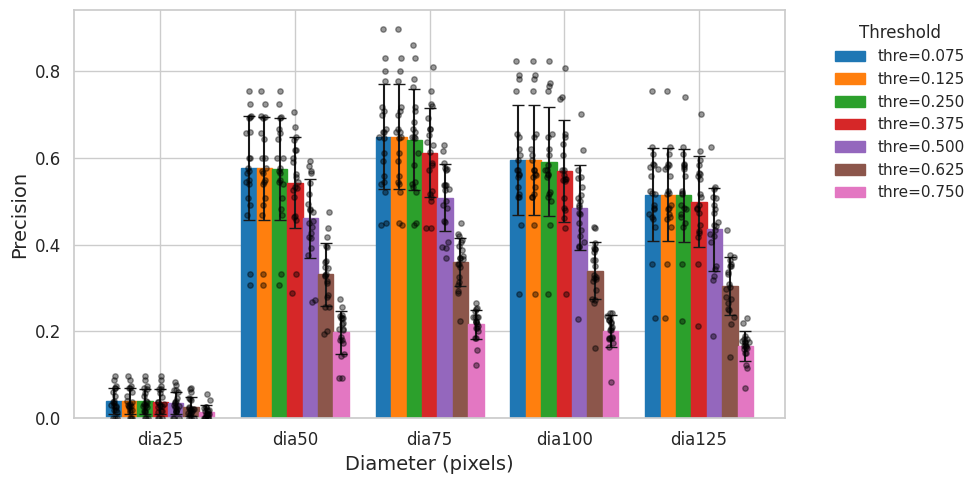

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
thre_list = sorted(output_2d['thre'].unique())
dia_list = sorted(output_2d['dia'].unique())
bar_width = 0.8 / len(thre_list)

# Prepare color palette
colors = sns.color_palette("tab10", n_colors=len(thre_list))

# Set up plot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(dia_list))  # positions for diameter groups

# Plot bars and individual points
for i, thre in enumerate(thre_list):
    means = output_2d[output_2d['thre'] == thre].groupby('dia')['precision'].mean()
    stds = output_2d[output_2d['thre'] == thre].groupby('dia')['precision'].std()

    for j, dia in enumerate(dia_list):
        bar_pos = x[j] + i * bar_width
        mean_val = means.loc[dia] if dia in means.index else np.nan
        std_val = stds.loc[dia] if dia in stds.index else 0

        # Plot bar
        ax.bar(bar_pos, mean_val, bar_width,
               color=colors[i], edgecolor=colors[i],
               yerr=std_val, capsize=4,
               label=f'thre={thre:.3f}' if j == 0 else None)

        # Scatter individual points
        subset = output_2d[(output_2d['thre'] == thre) & (output_2d['dia'] == dia)]
        jitter_x = np.random.normal(loc=bar_pos, scale=bar_width * 0.1, size=len(subset))
        ax.scatter(jitter_x, subset['precision'], color='black', s=15, alpha=0.4, zorder=3)

# Final formatting
ax.set_xticks(x + bar_width * (len(thre_list) - 1) / 2)
ax.set_xticklabels([f'dia{d}' for d in dia_list])
ax.set_xlabel('Diameter (pixels)', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.legend(title='Threshold', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()


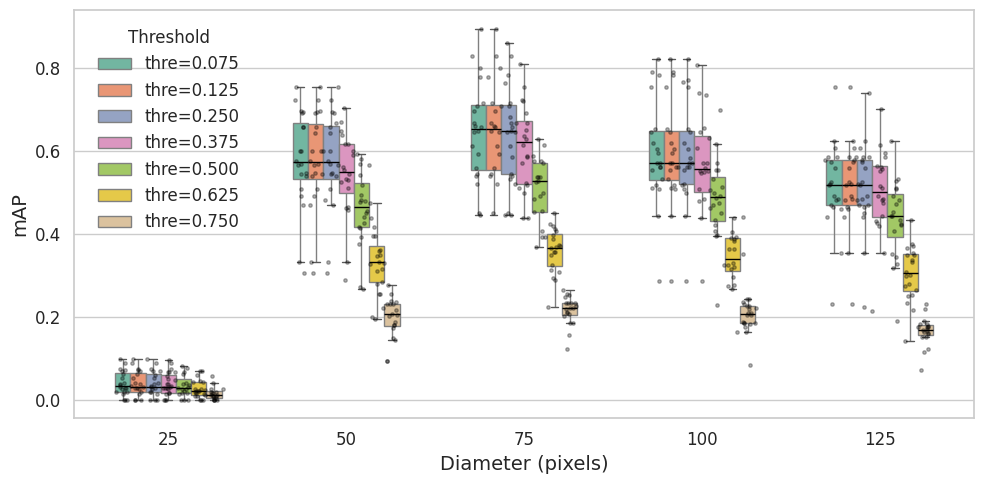

In [52]:
# Re-run code due to kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

output_2d['thre_str'] = output_2d['thre'].apply(lambda x: f"thre={x:.3f}")

thre_list = sorted(output_2d['thre'].unique())
dia_list = sorted(output_2d['dia'].unique())
n_thre = len(thre_list)
dodge_offset = 0.6 / n_thre

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))

# Draw boxplots
sns.boxplot(
    data=output_2d,
    x='dia',
    y='precision',
    hue='thre_str',
    palette='Set2',
    width=0.6,
    showcaps=True,
    boxprops={'edgecolor': 'gray'},
    medianprops={'color': 'black'},
    whiskerprops={'color': 'gray'},
    fliersize=0
)

# Compute offsets for strip points
for i, dia in enumerate(dia_list):
    for j, thre in enumerate(thre_list):
        subset = output_2d[(output_2d['dia'] == dia) & (output_2d['thre'] == thre)]
        x_vals = np.random.normal(loc=i - 0.3 + j * dodge_offset + dodge_offset / 2,
                                  scale=0.02, size=len(subset))
        plt.scatter(x_vals, subset['precision'], color='black', s=6, alpha=0.3, zorder=2)

# Format plot
plt.xlabel('Diameter (pixels)', fontsize=14)
plt.ylabel('mAP', fontsize=14)
plt.xticks(ticks=range(len(dia_list)), labels=[str(d) for d in dia_list], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(
    title='Threshold',
    loc='upper left',
    bbox_to_anchor=(0.01, 0.99),
    frameon=False,
    fontsize=12,
    title_fontsize=12
)
plt.tight_layout()

plt.show()
